## Beta bulge classification

- This notebook performs multi-class classification between the three classes in the data
- It uses a multinomial naive bayes classifier with some smoothing

Step 1: load the data

In [7]:
import csv

In [8]:
input_data = '../data/OneSheet.csv'
data = []
with open(input_data,'r') as f:
    reader = csv.reader(f)
    heads = next(reader)
    for line in reader:
        data.append(line)

Class is final column

- 0 = original
- 1 = a
- 2 = b

Step 2: randomly permute the data for cross-validation

- Using $K=10$ fold cross-validation

In [9]:
import numpy as np
data = np.random.permutation(data)
N = len(data)
fold_idxs = []
K = 10
fold_size = int(np.floor(N/K))
idx = list(range(N))
for k in range(K):
    this_fold = idx[k*fold_size:k*fold_size+fold_size]
    fold_idxs.append(this_fold)
fold_idxs[-1] += idx[K*fold_size:]

Create an index for the unique AAs

In [10]:
AA_idx = {}
aa_pos = 0
for d in data:
    for aa in d[:4]:
        if not aa in AA_idx:
            AA_idx[aa] = aa_pos
            aa_pos += 1
print(AA_idx)

{'P': 0, 'V': 1, 'I': 2, 'S': 3, 'F': 4, 'A': 5, 'W': 6, 'K': 7, 'L': 8, 'D': 9, 'R': 10, 'G': 11, 'E': 12, 'N': 13, 'T': 14, 'Y': 15, 'H': 16, 'C': 17, 'Q': 18, 'M': 19}


In [70]:
classes = [0,1,2]
beta = 1 # smoothing parameter
pred_probs = []
pred_labels = []



columns_to_use = [0,1,2,3] # these are the AA positions to use in the model change the list to remove some.



# loop over cross-validation folds
for k in range(K):
    test_idx = fold_idxs[k]
    train_X = []
    test_X = []
    train_t = []
    test_t = []
    for n in range(N):
        if not n in test_idx:
            train_X.append(data[n][columns_to_use]) # four amino acid positions
            train_t.append(int(data[n][4])) # class
        else:
            test_X.append(data[n][columns_to_use])
            test_t.append(int(data[n][4]))
            
    class_counts = {} # will hold the number of times we see each AA in each position in each class
    for class_no in classes:
        class_counts[class_no] = [[beta for aa in AA_idx] for i in range(len(columns_to_use))] # initialise with smoothing par
    
    # look over the training data, counting how many times we see each AA in each position
    for i,d in enumerate(train_X):
        class_no = train_t[i]
        for j,aa in enumerate(d):
            pos = AA_idx[aa]
            class_counts[class_no][j][pos] += 1
    
    # convery to probabilities
    class_probs = {}
    for class_no in classes:
        class_probs[class_no] = np.array(class_counts[class_no])
        class_probs[class_no] = class_probs[class_no]/class_probs[class_no].sum(axis=1)[:,None]

    # prior is proportional to the number of things in each class in the training set
    prior_counts = {}
    for class_no in classes:
        prior_counts[class_no] = len(list(filter(lambda x: x == class_no,train_t))) / len(train_t)
    
    for i,d in enumerate(test_X):
        probs = []
        for class_no in classes:
            class_prob = 1
            for j in range(len(columns_to_use)):
                aa = d[j]
                aa_pos = AA_idx[aa]
                class_prob *= class_probs[class_no][j][aa_pos]
            probs.append(class_prob*prior_counts[class_no])
        probs = np.array(probs)
        probs /= probs.sum()
        pred_probs.append(probs)
        pred_labels.append(test_t[i])
    

Compute performance via a confusion matrix. 

In [71]:
correct = 0
raw_pred = []
for i,probs in enumerate(pred_probs):
    raw_pred.append(np.argmax(probs))
    if raw_pred[i] == pred_labels[i]:
        correct += 1
n_pred = len(raw_pred)
print("Accuracy as a %age = {:.2f}".format(100*correct/n_pred))
confusion = np.zeros((3,3))
zz = list(zip(raw_pred,pred_labels))
for class_no in classes:
    for class_no2 in classes:
        confusion[class_no,class_no2] = len(list(filter(lambda x: x[0] == class_no and x[1] == class_no2,zz)))
print()
print("Confusion matrix: columns correspond to true classes, rows to predicted")
print("\t","\t".join([str(c) for c in classes]))
print("-------------------------------")
for i,row in enumerate(confusion):
    print(classes[i],"\t","\t".join(["{:n}".format(c) for c in row]))

Accuracy as a %age = 87.62

Confusion matrix: columns correspond to true classes, rows to predicted
	 0	1	2
-------------------------------
0 	 420	18	20
1 	 17	295	38
2 	 9	11	85


## Visualise the class probabilities

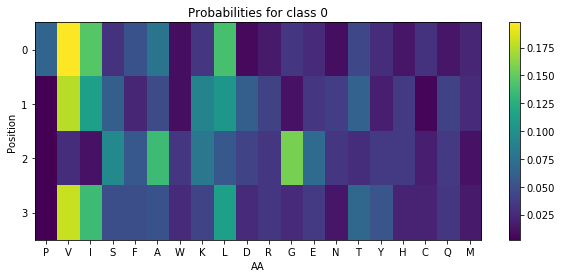

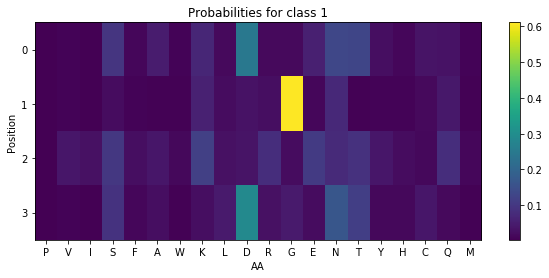

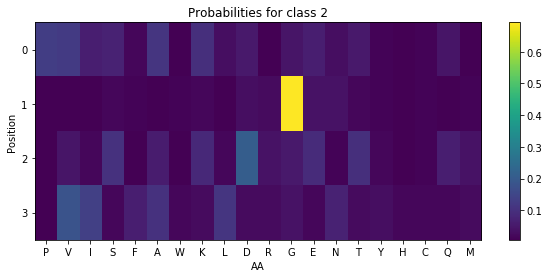

In [72]:
import pylab as plt
%matplotlib inline
AA_name_pos = list(AA_idx.items())
AA_name_pos.sort(key = lambda x: x[1])
sorted_AA_names,_ = zip(*AA_name_pos)
for c in classes:
    plt.figure(figsize=(10,4))
    plt.imshow(class_probs[c],aspect='auto')
    plt.xticks(range(len(sorted_AA_names)),sorted_AA_names)
    plt.yticks(columns_to_use,columns_to_use)
    plt.ylabel('Position')
    plt.xlabel('AA')
    plt.title("Probabilities for class {}".format(c))
    plt.colorbar()